Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_sex, beta_edu, beta_income]


Output()

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 33 seconds.
The number of samples is too small to check convergence reliably.
Only 10 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_age, beta_income]


Output()

Sampling 4 chains for 10 tune and 10 draw iterations (40 + 40 draws total) took 31 seconds.
The number of samples is too small to check convergence reliably.


Output()

Output()

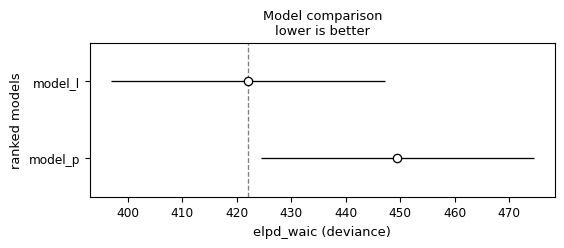


Model Comparison Results:
         rank   elpd_waic    p_waic  elpd_diff    weight         se  \
model_l     0  422.071860  4.168807   0.000000  0.992615  25.134787   
model_p     1  449.513658  3.917282  27.441798  0.007385  25.008290   

               dse  warning     scale  
model_l   0.000000    False  deviance  
model_p  10.500482    False  deviance  


In [8]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Read and prepare data
data = pd.read_csv('date_alegeri_turul2.csv')

# Standardize numerical variables
data['Varsta_std'] = (data['Varsta'] - data['Varsta'].mean()) / data['Varsta'].std()
data['Venit_std'] = (data['Venit'] - data['Venit'].mean()) / data['Venit'].std()

# Model with all variables
with pm.Model() as model_l:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_edu = pm.Normal('beta_edu', mu=0, sigma=10)
    beta_income = pm.Normal('beta_income', mu=0, sigma=10)
    
    # Linear combination
    mu = intercept + \
         beta_age * data['Varsta_std'] + \
         beta_sex * data['Sex'] + \
         beta_edu * data['Educatie'] + \
         beta_income * data['Venit_std']
    
    # Likelihood
    theta = pm.math.sigmoid(mu)
    y = pm.Bernoulli('y', p=theta, observed=data['Vot'])
    
    # Sampling
    idata_l = pm.sample(draws=10, tune=10, return_inferencedata=True)

# Model with just two variables (assuming Age and Income are most influential)
with pm.Model() as model_p:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_income = pm.Normal('beta_income', mu=0, sigma=10)
    
    # Linear combination
    mu = intercept + \
         beta_age * data['Varsta_std'] + \
         beta_income * data['Venit_std']
    
    # Likelihood
    theta = pm.math.sigmoid(mu)
    y = pm.Bernoulli('y', p=theta, observed=data['Vot'])
    
    # Sampling
    idata_p = pm.sample(draws=10, tune=10, return_inferencedata=True)

# Compare models
with model_l:
    pm.compute_log_likelihood(idata_l)
waic_l = az.waic(idata_l, scale="deviance")

with model_p:
    pm.compute_log_likelihood(idata_p)
waic_p = az.waic(idata_p, scale="deviance")

# Compare using BB-pseudo-BMA
comparison_df = az.compare(
    {'model_l': idata_l, 'model_p': idata_p},
    method='BB-pseudo-BMA',
    ic="waic",
    scale="deviance"
)

# Plot comparison
az.plot_compare(comparison_df)
plt.show()

# Print comparison results
print("\nModel Comparison Results:")
print(comparison_df)